In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# MT-Bench Human Annotation Dataset - Win Rate

In [2]:
def load_data(splits):
    human_df = pd.read_parquet("hf://datasets/lmsys/mt_bench_human_judgments/" + splits["human"])
    gpt_df = pd.read_parquet("hf://datasets/lmsys/mt_bench_human_judgments/" + splits["gpt4_pair"])
    return human_df, gpt_df

In [3]:
def process_model_data(human_df, gpt_df, model_name):
    # Filter for rows where the model is in the comparison
    model_human_df = human_df[(human_df["model_a"] == model_name) | (human_df["model_b"] == model_name)]
    model_llm_df = gpt_df[(gpt_df["model_a"] == model_name) | (gpt_df["model_b"] == model_name)]

    # Convert conversation columns to strings
    model_human_df["conversation_a"] = model_human_df["conversation_a"].astype(str)
    model_human_df["conversation_b"] = model_human_df["conversation_b"].astype(str)
    model_llm_df["conversation_a"] = model_llm_df["conversation_a"].astype(str)
    model_llm_df["conversation_b"] = model_llm_df["conversation_b"].astype(str)

    # Merge datasets
    merge_columns = ["question_id", "model_a", "model_b", "conversation_a", "conversation_b", "turn"]
    merged_df = pd.merge(model_human_df, model_llm_df, on=merge_columns, suffixes=("_human", "_gpt4"))

    # Keep relevant columns
    merged_df = merged_df[['question_id', 'model_a', 'model_b', 'winner_human', 'winner_gpt4']]
    
    return merged_df

In [4]:
def compute_win_rate(df, model_name, winner_col):
    # Compute the win rate of a specific model
    total_matches = len(df)
    wins = ((df["model_a"] == model_name) & (df[winner_col] == "model_a")) | ((df["model_b"] == model_name) & (df[winner_col] == "model_b"))
    return wins.sum() / total_matches

In [5]:
def convert_to_binary_indicators(df, model_name):
    # Convert winner columns to binary indicators
    binary_human = ((df["model_a"] == model_name) & (df["winner_human"] == "model_a")) | ((df["model_b"] == model_name) & (df["winner_human"] == "model_b"))
    binary_gpt4 = ((df["model_a"] == model_name) & (df["winner_gpt4"] == "model_a")) | ((df["model_b"] == model_name) & (df["winner_gpt4"] == "model_b"))
    
    df = df.copy()
    df["binary_human"] = binary_human.astype(float)
    df["binary_gpt4"] = binary_gpt4.astype(float)

    return df

In [6]:
def adjust_with_control_variates(df, sample_indices, tau):
    # Apply the control variates method to adjust the sampled estimate.

    sampled_df = df.iloc[sample_indices]
    
    covariance_m_t = np.cov(sampled_df["binary_human"], sampled_df["binary_gpt4"])[0, 1]
    var_t = sampled_df["binary_gpt4"].var()
    
    c_star = -covariance_m_t / var_t if var_t != 0 else 0
    
    adjusted_estimate = sampled_df["binary_human"].mean() + c_star * (sampled_df["binary_gpt4"].mean() - tau)
    
    return adjusted_estimate

In [7]:
def run_sampling_analysis(merged_df, model_name, sampling_rates, num_trials=1000):
    # Run sampling analysis with both uniform and control variates methods

    # Compute baseline metrics
    win_rate_human = compute_win_rate(merged_df, model_name, "winner_human")
    win_rate_llm = compute_win_rate(merged_df, model_name, "winner_gpt4")
    relative_error_llm = abs(win_rate_llm - win_rate_human) / win_rate_human * 100

    # Convert to binary indicators
    merged_df = convert_to_binary_indicators(merged_df, model_name)
    
    # Sampling analysis
    np.random.seed(42)
    avg_relative_errors = []
    avg_relative_errors_control_variates = []
    
    for rate in sampling_rates:
        sample_size = int(rate * len(merged_df))
        relative_errors = []
        relative_errors_control_variates = []
        
        for i in range(num_trials):
            sample_indices = np.random.choice(len(merged_df), size=sample_size, replace=False)
            sampled_df = merged_df.iloc[sample_indices]
            
            # Uniform sampling
            uniform_win_rate = sampled_df["binary_human"].mean()
            relative_error = abs(uniform_win_rate - win_rate_human) / win_rate_human * 100
            relative_errors.append(relative_error)
            
            # Control variates
            adjusted_win_rate = adjust_with_control_variates(merged_df, sample_indices, win_rate_llm)
            relative_error_cv = abs(adjusted_win_rate - win_rate_human) / win_rate_human * 100
            relative_errors_control_variates.append(relative_error_cv)
        
        avg_relative_errors.append(np.mean(relative_errors))
        avg_relative_errors_control_variates.append(np.mean(relative_errors_control_variates))
    
    return {
        'win_rate_human': win_rate_human,
        'win_rate_llm': win_rate_llm,
        'relative_error_llm': relative_error_llm,
        'avg_relative_errors': avg_relative_errors,
        'avg_relative_errors_cv': avg_relative_errors_control_variates
    }

In [8]:
def plot_results(results, sampling_rates, dataset_size, model_name):
    # Plot the analysis results
    
    plt.figure(figsize=(10, 6))
    plt.plot(sampling_rates * dataset_size, results['avg_relative_errors'], 
             '-', color='blue', label='Uniform Sampling')
    plt.plot(sampling_rates * dataset_size, results['avg_relative_errors_cv'], 
             '-', color='green', label='With Control Variates')
    plt.axhline(y=results['relative_error_llm'], color='red', 
                linestyle='--', label='LLM Baseline')

    plt.xlabel("# Human Labels")
    plt.ylabel("Relative Error (%)")
    plt.legend()
    plt.grid(True)
    plt.title(f"Relative Error of Win Rate Estimation for {model_name}")
    plt.show()

In [10]:
def analyze_model(model_name, splits, num_trials=1000):
    # Run complete analysis for a specific model
    sampling_rates = np.linspace(0.001, 0.2, 20)
    
    # Load and process data
    human_df, gpt_df = load_data(splits)
    merged_df = process_model_data(human_df, gpt_df, model_name)
    
    # Run analysis
    results = run_sampling_analysis(merged_df, model_name, sampling_rates, num_trials)
    
    # Print results
    print(f"\nResults for {model_name}:")
    print(f"Win Rate (Human Judges): {results['win_rate_human']:.3f}")
    print(f"Win Rate (LLM Judges): {results['win_rate_llm']:.3f}")
    print(f"Relative Error (LLM vs. Human): {results['relative_error_llm']:.2f}%")
    
    # Plot results
    plot_results(results, sampling_rates, len(merged_df), model_name)
    
    return results

/tmp/ipykernel_32117/1896196427.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_human_df["conversation_a"] = model_human_df["conversation_a"].astype(str)
/tmp/ipykernel_32117/1896196427.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_human_df["conversation_b"] = model_human_df["conversation_b"].astype(str)
/tmp/ipykernel_32117/1896196427.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea


Results for gpt-3.5-turbo:
Win Rate (Human Judges): 0.504
Win Rate (LLM Judges): 0.450
Relative Error (LLM vs. Human): 10.69%


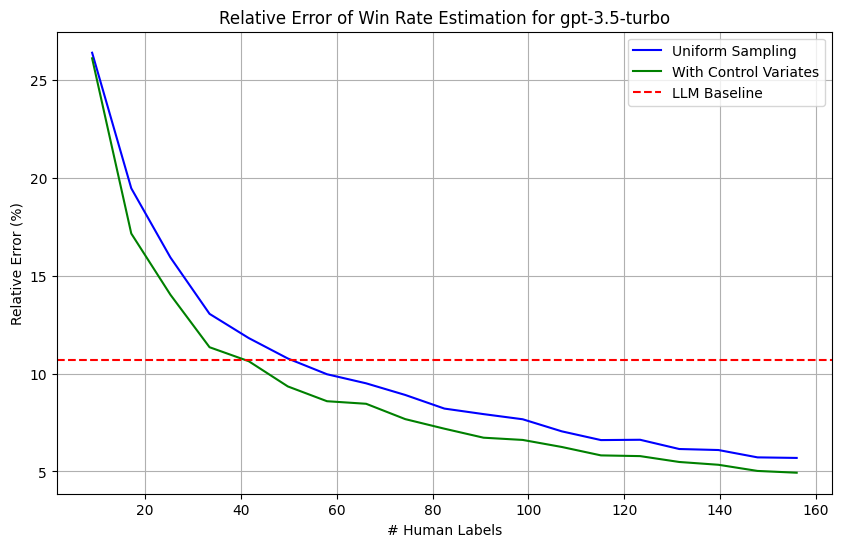

/tmp/ipykernel_32117/1896196427.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_human_df["conversation_a"] = model_human_df["conversation_a"].astype(str)
/tmp/ipykernel_32117/1896196427.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_human_df["conversation_b"] = model_human_df["conversation_b"].astype(str)
/tmp/ipykernel_32117/1896196427.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea


Results for claude-v1:
Win Rate (Human Judges): 0.495
Win Rate (LLM Judges): 0.512
Relative Error (LLM vs. Human): 3.30%


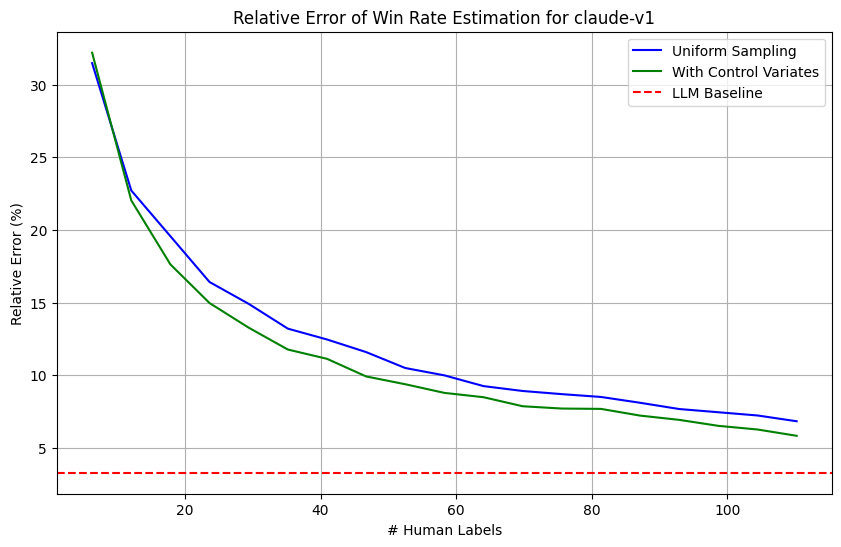

/tmp/ipykernel_32117/1896196427.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_human_df["conversation_a"] = model_human_df["conversation_a"].astype(str)
/tmp/ipykernel_32117/1896196427.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_human_df["conversation_b"] = model_human_df["conversation_b"].astype(str)
/tmp/ipykernel_32117/1896196427.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea


Results for vicuna-13b-v1.2:
Win Rate (Human Judges): 0.326
Win Rate (LLM Judges): 0.307
Relative Error (LLM vs. Human): 5.82%


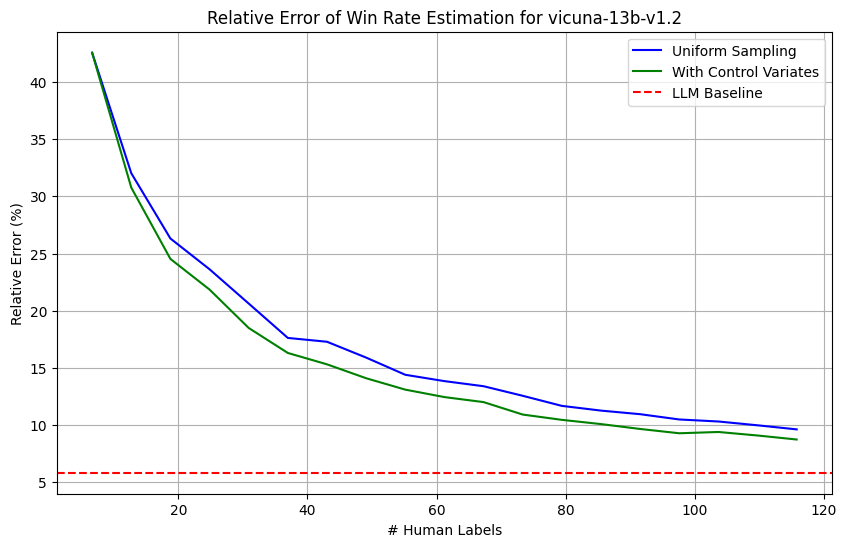

/tmp/ipykernel_32117/1896196427.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_human_df["conversation_a"] = model_human_df["conversation_a"].astype(str)
/tmp/ipykernel_32117/1896196427.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_human_df["conversation_b"] = model_human_df["conversation_b"].astype(str)
/tmp/ipykernel_32117/1896196427.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea


Results for llama-13b:
Win Rate (Human Judges): 0.076
Win Rate (LLM Judges): 0.016
Relative Error (LLM vs. Human): 78.57%


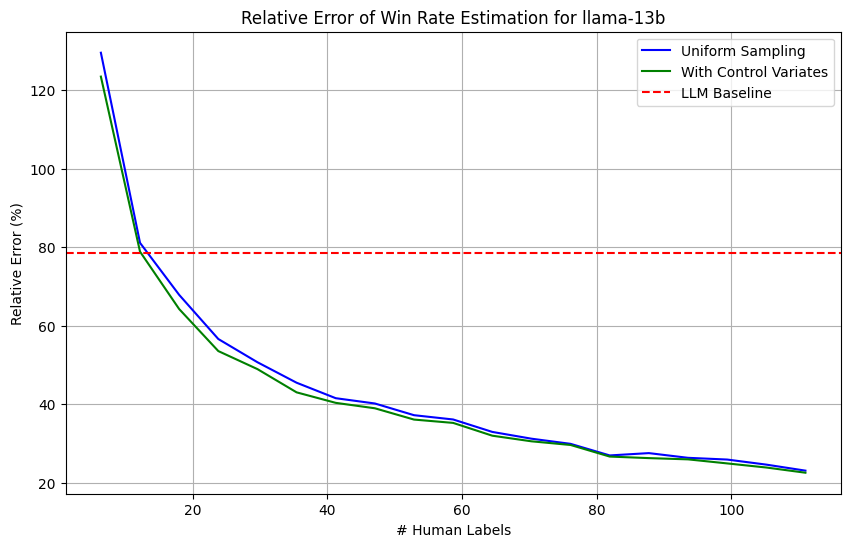

/tmp/ipykernel_32117/1896196427.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_human_df["conversation_a"] = model_human_df["conversation_a"].astype(str)
/tmp/ipykernel_32117/1896196427.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_human_df["conversation_b"] = model_human_df["conversation_b"].astype(str)
/tmp/ipykernel_32117/1896196427.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea


Results for gpt-4:
Win Rate (Human Judges): 0.623
Win Rate (LLM Judges): 0.770
Relative Error (LLM vs. Human): 23.55%


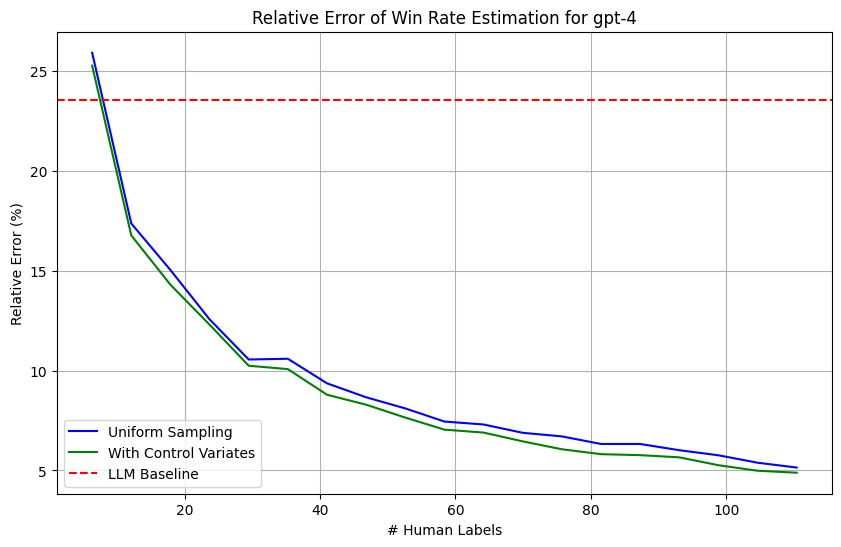

/tmp/ipykernel_32117/1896196427.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_human_df["conversation_a"] = model_human_df["conversation_a"].astype(str)
/tmp/ipykernel_32117/1896196427.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_human_df["conversation_b"] = model_human_df["conversation_b"].astype(str)
/tmp/ipykernel_32117/1896196427.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea


Results for alpaca-13b:
Win Rate (Human Judges): 0.192
Win Rate (LLM Judges): 0.140
Relative Error (LLM vs. Human): 26.88%


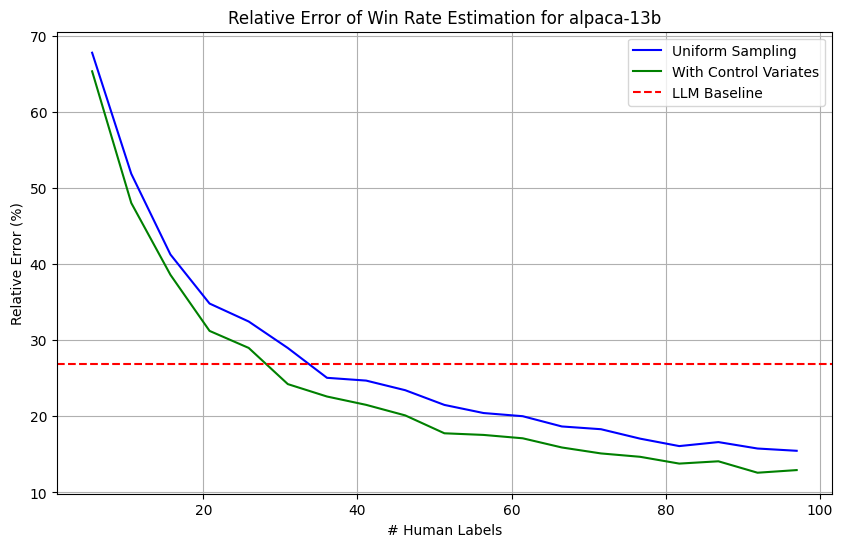

{'win_rate_human': 0.19175257731958764,
 'win_rate_llm': 0.1402061855670103,
 'relative_error_llm': 26.88172043010753,
 'avg_relative_errors': [nan,
  67.81505376344086,
  51.894623655913975,
  41.28709677419354,
  34.83306451612903,
  32.471397849462356,
  28.98530465949821,
  25.066965352449223,
  24.70254392866509,
  23.436582515194015,
  21.502951718321736,
  20.435368663594467,
  20.019513484928606,
  18.67072336265884,
  18.30870816295623,
  17.067925863044707,
  16.0891411124386,
  16.61506626656664,
  15.769384379061796,
  15.470967741935484],
 'avg_relative_errors_cv': [nan,
  65.37168458781362,
  48.056816436251914,
  38.61479230446972,
  31.236195042750893,
  28.997172391945952,
  24.238807149115864,
  22.607563483076056,
  21.512202500000797,
  20.122335380346218,
  17.772966511741586,
  17.557597615025067,
  17.114845666891647,
  15.907675003839064,
  15.123901525194112,
  14.68096334276472,
  13.78718366921338,
  14.0900666593073,
  12.587285013622768,
  12.93389157677258

In [11]:
# GPT-3.5 Turbo
analyze_model(
    model_name="gpt-3.5-turbo",
    splits={'gpt4_pair': 'data/gpt4_pair-00000-of-00001-c0b431264a82ddc0.parquet', 
        'human': 'data/human-00000-of-00001-25f4910818759289.parquet'}
)

# Analyze Claude-v1
analyze_model(
    model_name="claude-v1",
    splits={'gpt4_pair': 'data/gpt4_pair-00000-of-00001-c0b431264a82ddc0.parquet', 
        'human': 'data/human-00000-of-00001-25f4910818759289.parquet'}
)

# Analyze Vicuna-13b-v1.2
analyze_model(
    model_name="vicuna-13b-v1.2",
    splits={'gpt4_pair': 'data/gpt4_pair-00000-of-00001-c0b431264a82ddc0.parquet', 
        'human': 'data/human-00000-of-00001-25f4910818759289.parquet'}
)

# Analyze Llama-13b
analyze_model(
    model_name="llama-13b",
    splits={'gpt4_pair': 'data/gpt4_pair-00000-of-00001-c0b431264a82ddc0.parquet', 
        'human': 'data/human-00000-of-00001-25f4910818759289.parquet'}
)

# Analyze GPT-4
analyze_model(
    model_name="gpt-4",
    splits={'gpt4_pair': 'data/gpt4_pair-00000-of-00001-c0b431264a82ddc0.parquet', 
        'human': 'data/human-00000-of-00001-25f4910818759289.parquet'}
)

# Analyze alpaca-13b
analyze_model(
    model_name="alpaca-13b",
    splits={'gpt4_pair': 'data/gpt4_pair-00000-of-00001-c0b431264a82ddc0.parquet', 
        'human': 'data/human-00000-of-00001-25f4910818759289.parquet'}
)